<a href="https://colab.research.google.com/github/thaCripple/SkinLesionClassifier_v2/blob/main/slc_v2_traindata_oversampling.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Oversampling the minority classes to balance the dataset

We know the dataset is quite imbalanced. We will try to implement oversampling through image augmentation to partially balance the classes alongside assigning weights to classes in the loss function during model training

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import torch
from pathlib import Path
from PIL import Image
import torchvision
from torchvision.transforms import v2
from typing import Literal

In [ ]:
DRIVE_DIR = Path("/content/drive/MyDrive")

In [ ]:
imgs_dir = DRIVE_DIR / "skin_lesions"

# The Oversampler Class

In [ ]:
class Oversampler:
  """
  Generates new training samples by augmenting the original images with the specified transforms for all classes present in a specified directory.
  Creates as many images as needed to balance the classes without exceeding a specified ratio of original: generated samples.
  Use `generate_images()` to oversample a single class or `balance_classes()` to generate images for every class in the train directory.

  # Parameters:
    samples_dir: Path to directory where `train` and `test` folders are located.
    augments_list: [Optional] list of transforms to use for image augmentation.
    max_generated: [Optional] maximum ratio of generated to original images desired.

  """

  def __init__(self,
               samples_dir:Path,
               augments_list:list|None=None,
               max_generated:int=3) -> None:

    # super().__init__()
    self.samples_dir = samples_dir
    self.max_generated = max_generated

    # Create the v2.Compose()
    if augments_list is not None:
      self.augments_list = augments_list
    else:
      self.augments_list = [
      v2.RandomHorizontalFlip(p=0.3),
      v2.RandomVerticalFlip(p=0.3),
      v2.RandomRotation(degrees=30),
      v2.RandomPerspective(distortion_scale=0.1, p=0.7)]
      # Apply the Blur only 30% of the time
      self.augments_list.append(v2.RandomApply(transforms=[v2.GaussianBlur(kernel_size=(5, 9), sigma=(0.1, 5))], p=0.3))

    self.augments = v2.Compose(transforms=self.augments_list)

    # Create a list with all the class names
    self.class_names = self.get_class_names()

    # Create a dict with paths to all images for all the classes
    self.all_images = self.get_class_images()

    # Number of original images in each class and count of images in the biggest class
    self.class_counts, self.most_samples = self.count_samples()

    # How many images to generate per class
    self.samples_to_generate_per_class = self.count_number_to_gen()


  def get_class_names(self)->list:
    """ Returns a list all the class names"""
    return [path.name for path in self.samples_dir.glob("train/*")]


  def get_class_images(self)->dict[str,list]:
    """
    Returns a dictionary of class name: list of all Paths to images in that class
    """

    all_images = {}
    for img_class in self.class_names:
      class_dir = Path(self.samples_dir / "train" / img_class)
      all_images[img_class] = list(class_dir.glob("*.jpg")) + list(class_dir.glob("*.png"))
    return all_images

  def count_samples(self)->tuple[dict, int]:
    """
    Returns a dictionary with the number of samples present in each category
    and the number of samples in the largest category

    # Returns:
      A dictionary with "class_name": number_of_samples,
      Number of samples in the largest category
    """
    class_counts = {}
    most_samples = 0

    for class_name, imgs_paths in self.all_images.items():
      class_img_count = len(imgs_paths)
      class_counts[class_name] = class_img_count
      if class_img_count > most_samples:
        most_samples = class_img_count

    return class_counts, most_samples


  def count_number_to_gen(self)->dict[str:int]:
    """
    Count how many images need to be generated to match the most numerous class, without exceeding
    a specified number of times the original image count.

    # Returns
    A dictionary with class_name: number of samples to generate
    """
    samples_to_generate_per_class = {}

    for class_name, orignal_img_count in self.class_counts.items():
      if orignal_img_count < self.most_samples:
        samples_to_gen = self.most_samples - orignal_img_count
        # Don't generate more than max_generated times the original images' number
        if samples_to_gen > orignal_img_count:
          samples_to_gen = self.max_generated * orignal_img_count

        samples_to_generate_per_class[class_name] = samples_to_gen
    return samples_to_generate_per_class


  def generate_images(self, class_name:str, samples_to_generate:int|None=None)->None:
    """
    Generates images for a single class and saves them in the original directory.

    # Parameters:
      class_name: name of the class to generate images for
      samples_to_generate: [Optional] how many images to generate. If None generate a number of images calculated internaly.
    """
    if samples_to_generate is not None:
      num_to_gen = samples_to_generate
    else:
      num_to_gen = self.samples_to_generate_per_class[class_name]

    generated_imgs_count = 0
    original_imgs_count = self.class_counts[class_name]

    i = 0
    while generated_imgs_count < num_to_gen:
      if i >= original_imgs_count:
        # keep itearting over the original images only. Avoids Indexoutofrange error
        i = i - (i // original_imgs_count)*original_imgs_count

      original_img_path = self.all_images[class_name][i]
      # get an original image in PIL format
      original_img = Image.open(original_img_path)
      # generate a new image
      generated_img = self.augments(original_img)
      # save the new image
      generated_img_path = (original_img_path.parent / f"aug_{original_img_path.stem}_{str(generated_imgs_count) + original_img_path.suffix}")
      generated_img.save(fp=generated_img_path)

      generated_imgs_count += 1
      i += 1
    print(f"Generated {generated_imgs_count} images from {original_imgs_count} originial images for class {class_name}.")


  def balance_classes(self)->None:
    """
    Generates new samples by augmenting the original images with the specified transforms for all classes.
    """

    for class_name in self.samples_to_generate_per_class.keys():
      self.generate_images(class_name=class_name)

# Balancing classes by oversampling

In [ ]:
ovs0 = Oversampler(samples_dir=imgs_dir)

Number of images per class before oversampling

In [ ]:
ovs0.class_counts

{'akiec': 370,
 'bcc': 607,
 'bkl': 1316,
 'df': 159,
 'mel': 1284,
 'nv': 7613,
 'vasc': 177}

Most numerous class

In [ ]:
ovs0.most_samples

7613

How many images will be generated

In [ ]:
ovs0.samples_to_generate_per_class

{'akiec': 1110, 'bcc': 1821, 'bkl': 3948, 'df': 477, 'mel': 3852, 'vasc': 531}

In [ ]:
ovs0.balance_classes()

Generated 1110 images from 370 originial images for class akiec.
Generated 1821 images from 607 originial images for class bcc.
Generated 3948 images from 1316 originial images for class bkl.
Generated 477 images from 159 originial images for class df.
Generated 3852 images from 1284 originial images for class mel.
Generated 531 images from 177 originial images for class vasc.


Done!

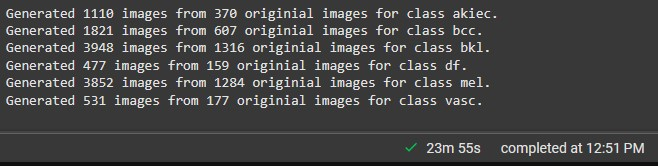

# Create a custom torch.utils.data.Dataset
I'd like to create a custom Dataset that can:
- retrieve either only original images or original+generated
- retrieve only a portion of samples present in a directory
- be compatible with `torch.DataLoader`

[help resource](https://pytorch.org/tutorials/beginner/basics/data_tutorial.html#creating-a-custom-dataset-for-your-files)

### def create_metadata(self)

I want a df with columns: idx **|** image name **|** class name **|** wether original or fake

each row will be a single sample image


In [ ]:
def create_metadata(root_dir:Path, subset:Literal["train", "test"]="train", save_created_metadata:bool=False, save_path:Path|None=None)->pd.DataFrame:
  """
  Creates a pandas DataFrame with metadata extracted from the samples' directory structure required for the CustomImageDataset.
  Optionally saves the DataFrame to a .csv file.

  # Parameters:
    root_dir: Path to directory where `train` and `test` folders are located

    subset - One of ["train", "test"]: Wether to create a training or testing dataset

    save_created_metadata: Wether to save the created metadata to a .csv file

    save_path: Existing directory to save the .csv file to. If not specified will save to current working directory

  # Returns:
    A dataframe with metadata extracted from the samples' directory structure
  """

  # Path to the subset of images in the directory
  imgs_dir = Path(root_dir / subset)

  metadata_dict = {
      "image_name": [],
      "class_name": [],
      "original": []}

  # Get class names
  class_names = [path.name for path in list(Path(imgs_dir).glob("*"))]

  # Get full paths to all the images in the directory
  for class_name in class_names:
    all_image_paths_in_class = list(Path(imgs_dir / class_name).glob("*.jpg")) + list(Path(imgs_dir / class_name).glob("*.png"))
    for image_path in all_image_paths_in_class:
      metadata_dict["image_name"].append(image_path.name)
      metadata_dict["class_name"].append(class_name)
      # Check if the image is original based on the prefix in its name
      if image_path.stem.startswith("aug_"):
        metadata_dict["original"].append(False)
      else:
        metadata_dict["original"].append(True)

  # Create a dataframe
  metadata_df = pd.DataFrame(data=metadata_dict)

  # Optinally save the created dataframe to a .csv file
  if save_created_metadata:
    # Where to save
    if save_path is None:
      save_path = Path.cwd() / f"{subset}_metadata.csv"
    else:
      save_path = Path(save_path / f"{subset}_metadata.csv")

    metadata_df.to_csv(save_path, index=False)

  return metadata_df

In [ ]:
create_metadata(root_dir=imgs_dir, subset="train", save_created_metadata=True, save_path=Path("/content/drive/MyDrive/skin_lesion_classifier_v2"))

,image_name,class_name,original
0,ISIC_0024329.jpg,akiec,True
1,ISIC_0024372.jpg,akiec,True
2,ISIC_0024418.jpg,akiec,True
3,ISIC_0024450.jpg,akiec,True
4,ISIC_0024463.jpg,akiec,True
...,...,...,...
23260,aug_ISIC_0035931_526.jpg,vasc,False
23261,aug_ISIC_0035925_527.jpg,vasc,False
23262,aug_ISIC_0035946_528.jpg,vasc,False
23263,aug_ISIC_0035952_529.jpg,vasc,False


In [ ]:
create_metadata(root_dir=imgs_dir, subset="test", save_created_metadata=True, save_path=Path("/content/drive/MyDrive/skin_lesion_classifier_v2"))

,image_name,class_name,original
0,ISIC_0034536.jpg,akiec,True
1,ISIC_0034538.jpg,akiec,True
2,ISIC_0034579.jpg,akiec,True
3,ISIC_0034585.jpg,akiec,True
4,ISIC_0034669.jpg,akiec,True
...,...,...,...
1506,ISIC_0035931.jpg,vasc,True
1507,ISIC_0035925.jpg,vasc,True
1508,ISIC_0035946.jpg,vasc,True
1509,ISIC_0035952.jpg,vasc,True


In [ ]:
train_df = pd.read_csv(Path("/content/drive/MyDrive/skin_lesion_classifier_v2/train_metadata.csv"))
train_df

,image_name,class_name,original
0,ISIC_0024329.jpg,akiec,True
1,ISIC_0024372.jpg,akiec,True
2,ISIC_0024418.jpg,akiec,True
3,ISIC_0024450.jpg,akiec,True
4,ISIC_0024463.jpg,akiec,True
...,...,...,...
23260,aug_ISIC_0035931_526.jpg,vasc,False
23261,aug_ISIC_0035925_527.jpg,vasc,False
23262,aug_ISIC_0035946_528.jpg,vasc,False
23263,aug_ISIC_0035952_529.jpg,vasc,False


In [ ]:
train_df['class_name'].value_counts()

,count
class_name,
nv,7613
bkl,5264
mel,5136
bcc,2428
akiec,1480
vasc,708
df,636


## Create a custom ImageDataset class

In [ ]:
class CustomImageDataset(torch.utils.data.Dataset):
  """
  A custom dataset createor based on the functionality of torch.ImageFolder. Compatible with torch.DataLoader.
  Can load only original or generated images. Can load only a specified portion of the samples.

  # Parameters:
    root_dir: Path to directory where `train` and `test` folders are located

    metadata: A Path to a .csv file with dataset metadata or a pandas DataFrame directly

    subset - One of ["train", "test"]: Wether to load training or testing images

    original_only - Wether to use only original images

    portion - How large a part of all images to include

    transform - torchvision transforms to apply to the images (same as torch.Dataset)

    target_transform - transforms to apply to the labels (same as torch.Dataset)

  """

  def __init__(self, root_dir:Path, metadata:Path|pd.DataFrame, subset:Literal["train", "test"]="train", original_only:bool=False, portion:float|None=None, transform=None, target_transform=None) -> None:
    super().__init__()
    self.root_dir = root_dir
    self.subset = subset
    self.transform = transform
    self.target_transform = target_transform
    self.metadata = metadata
    self.original_only = original_only
    self.portion = portion

    # Path to the subdirectory
    self.imgs_dir = Path(self.root_dir / self.subset)

    # Load the metadata from a file
    if isinstance(self.metadata, Path):
      self.metadata_df = pd.read_csv(self.metadata)
    # or get it from the passed argument
    elif isinstance(self.metadata, pd.DataFrame):
      self.metadata_df = self.metadata.copy()

    # Only consider original images
    if self.original_only:
      self.metadata_df = self.metadata_df.loc[self.metadata_df['original'] == True]

    # Get only a portion of the samples. Since this is called after original_only was taken into account we don't have to do anythin special :D
    if self.portion is not None:
      self.metadata_df = self.get_metadata_df_portion()

    # Create class to integer mappings
    self.classes, self.class_to_idx = self.find_classes()


  def find_classes(self)-> tuple[np.array, dict[str, int]]:
    """
    Assigns integer representations to all the classes in the dataset
    # Returns:
    A tuple with an array of all class names and a dictionary with class to integer mappings
    """
    classes = np.sort(self.metadata_df["class_name"].unique())
    class_to_idx = {class_name: i for i, class_name in enumerate(classes)}
    return classes, class_to_idx

  def get_metadata_df_portion(self)->pd.DataFrame:
    """
    Returns the metadata_df with the number of samples for each class reduced according to the portion parameter.
    """
    total_samples_per_class = self.metadata_df['class_name'].value_counts().to_dict()
    portion_samples_per_class = {class_name: int(num_samples*self.portion) for class_name, num_samples in total_samples_per_class.items()}

    new_df_sections = []
    for class_name, num_samples in portion_samples_per_class.items():
      new_df_sections.append(self.metadata_df.loc[self.metadata_df['class_name'] == class_name].iloc[:num_samples])

    return pd.concat(objs=new_df_sections, axis=0)


  def __len__(self):
    return len(self.metadata_df)

  def __getitem__(self, idx):
    img_path = Path(self.imgs_dir, self.metadata_df["class_name"].iloc[idx], self.metadata_df["image_name"].iloc[idx])
    image = torchvision.io.decode_image(img_path)
    label = self.class_to_idx[self.metadata_df["class_name"].iloc[idx]]
    if self.transform:
            image = self.transform(image)
    if self.target_transform:
        label = self.target_transform(label)
    return image, label

### See if it works

In [ ]:
transforms = v2.Compose([v2.CenterCrop(244), v2.Resize(244), v2.ToImage(), v2.ToDtype(torch.float32, scale=True)])

In [ ]:
train_ds = CustomImageDataset(root_dir=imgs_dir,
                              metadata=Path("/content/drive/MyDrive/skin_lesion_classifier_v2/train_metadata.csv"),
                              subset="train",
                              transform=transforms,
                              portion=.3)

In [ ]:
test_ds = CustomImageDataset(root_dir=imgs_dir,
                             metadata=Path("/content/drive/MyDrive/skin_lesion_classifier_v2/test_metadata.csv"),
                             subset="test",
                             transform=transforms)

In [ ]:
train_ds.class_to_idx

{'akiec': 0, 'bcc': 1, 'bkl': 2, 'df': 3, 'mel': 4, 'nv': 5, 'vasc': 6}

In [ ]:
test_ds.class_to_idx

{'akiec': 0, 'bcc': 1, 'bkl': 2, 'df': 3, 'mel': 4, 'nv': 5, 'vasc': 6}

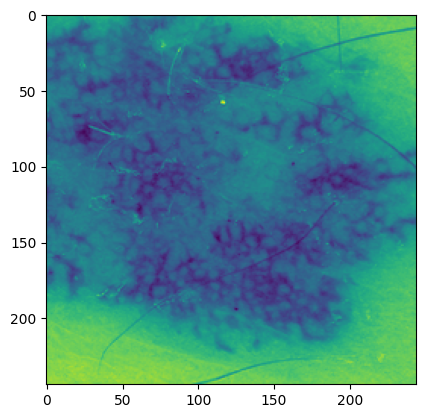

In [ ]:
plt.imshow(train_ds[4][0][0])

In [ ]:
train_dl = torch.utils.data.DataLoader(dataset=train_ds, batch_size=1, shuffle=True, num_workers=2, pin_memory=True)

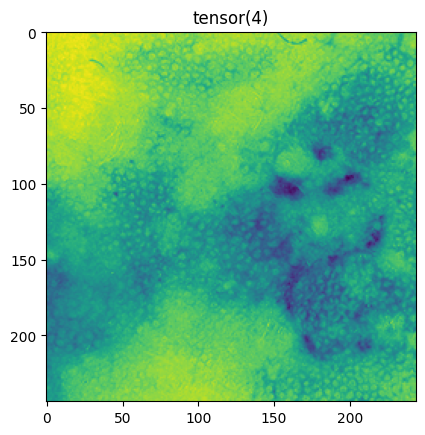

In [ ]:
fig, ax = plt.subplots(1,1)
for x_batch, y_batch in train_dl:

  ax.imshow(x_batch[0][0])
  ax.set_title(y_batch[0])

  break

# It works!! :D